In [10]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory,get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward,MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

{'Main_knee_2': (-0.30000000000000004, -0.1)}
[-0.3]


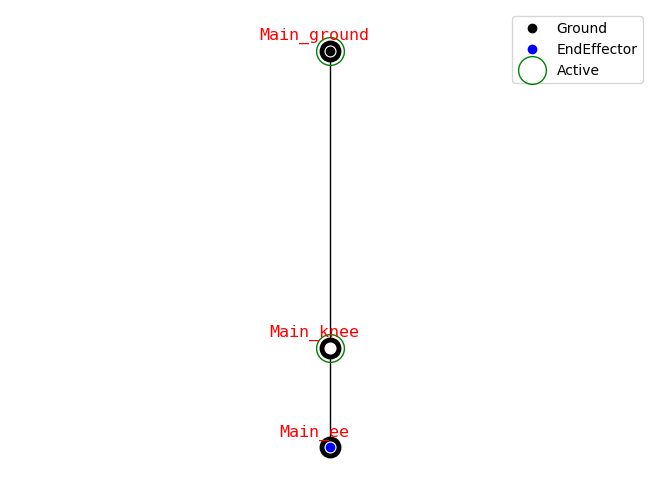

In [11]:
from auto_robot_design.generator.topologies.five_bar_manager import GraphManager2L

gm = GraphManager2L()
gm.reset()
gm.build_main(0.4,fully_actuated=True)
gm.set_mutation_ranges()
print(gm.mutation_ranges)
center = gm.generate_central_from_mutation_range()
center[0]=-0.3
print(center)
graph = gm.get_graph(center)
draw_joint_point(graph)

In [12]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

In [13]:
x = 0.12
y = 0.33
print((x**2+y**2)**0.5)
h= 0.1
y-h

0.35114099732158877


0.23

In [14]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))


# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])



# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(min_velocity, 0, 1)


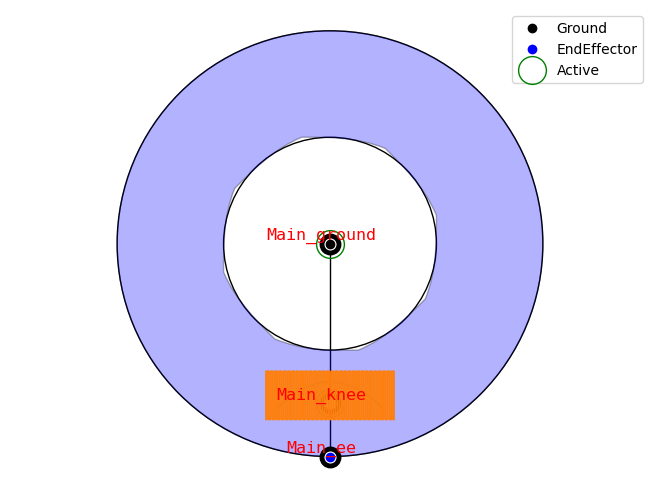

In [15]:
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path
draw_joint_point(graph)
# Parameters for the circles
center = (0, 0)
radius1 = 0.4
radius2 = 0.2

# Create a figure and axis
ax = plt.gca()

# Define the outer and inner circles
outer_circle = Circle(center, radius1, edgecolor='black', facecolor='none')
inner_circle = Circle(center, radius2, edgecolor='black', facecolor='none')

# Add circles to the plot
ax.add_patch(outer_circle)
ax.add_patch(inner_circle)

# Create the paths for the circles
outer_path = Path.circle(center=center, radius=radius1)
inner_path = Path.circle(center=center, radius=radius2)

# Create the path patch for the area between the circles
vertices = np.concatenate([outer_path.vertices, inner_path.vertices[::-1]])
codes = np.concatenate([outer_path.codes, inner_path.codes])
path = Path(vertices, codes)
patch = PathPatch(path, facecolor='blue', alpha=0.3)

# Add the path patch to the plot
ax.add_patch(patch)
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

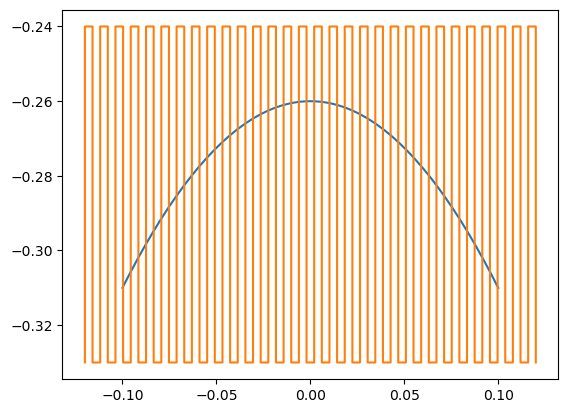

In [16]:


for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [17]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)


In [18]:
from pymoo.algorithms.moo.age2 import AGEMOEA2

population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm,builder, reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

     1 |       32 |      3 |  0.0532743857 |         ideal
     2 |       64 |      5 |  0.0411129138 |             f
     3 |       96 |      6 |  0.0455806989 |         ideal
     4 |      128 |     13 |  0.0061831495 |             f
     5 |      160 |     26 |  0.0122731997 |             f
     6 |      192 |     32 |  0.0025448510 |             f
     7 |      224 |     32 |  0.0053886208 |         ideal
     8 |      256 |     32 |  0.0014911333 |             f
     9 |      288 |     32 |  0.0026438164 |             f
    10 |      320 |     32 |  0.0012515735 |             f
    11 |      352 |     32 |  0.0018756631 |             f
    12 |      384 |     32 |  0.0022363011 |             f
    13 |      416 |     32 |  0.0030152037 |             f
    14 |      448 |     32 |  0.0004075999 |             f
    15 |      480 |     32 |  0.0008704822 |             f
    16 |      512 |     32 |  0.0011594680 |             f
    17 |      544 |     32 |  0.0017141950 |            

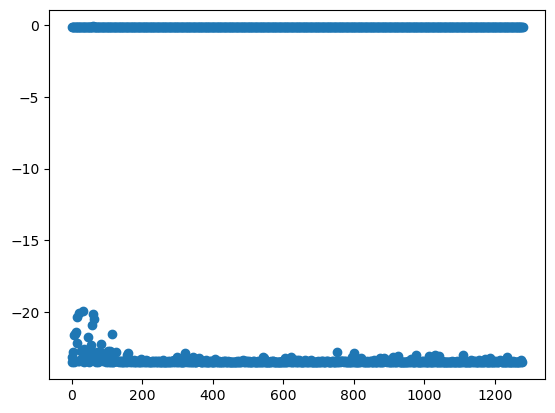

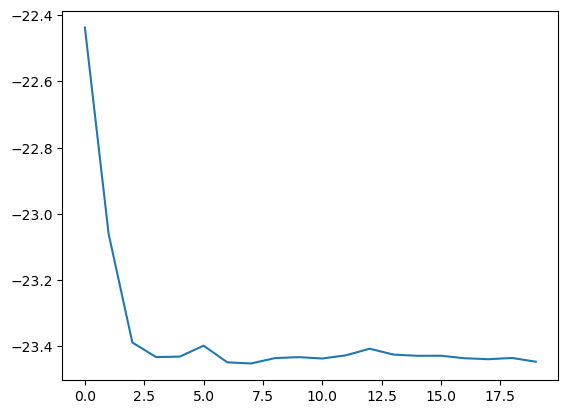

In [19]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean[:,0])
plt.show()

In [20]:
flatten_history

array([-23.48557474,  -0.14158219, -23.08959071, ...,  -0.13829166,
       -23.48185889,  -0.14179304])

In [21]:
history_mean

array([[-22.43723603,  -0.13702454],
       [-23.06026605,  -0.14488349],
       [-23.38802068,  -0.14605174],
       [-23.43203057,  -0.14644738],
       [-23.43069656,  -0.1454319 ],
       [-23.39759445,  -0.14516333],
       [-23.44790049,  -0.14421495],
       [-23.45138227,  -0.14458598],
       [-23.4352596 ,  -0.14391946],
       [-23.43218299,  -0.14388287],
       [-23.4364079 ,  -0.14437096],
       [-23.42669352,  -0.14624212],
       [-23.40678682,  -0.14470803],
       [-23.42447111,  -0.14345569],
       [-23.42820089,  -0.14346863],
       [-23.42797612,  -0.14290422],
       [-23.43558158,  -0.14201083],
       [-23.43847793,  -0.14392137],
       [-23.43477354,  -0.14395708],
       [-23.44602599,  -0.14232303]])

Scale f1: [-23.493757728709227, -23.41351033872493]
Scale f2: [-0.15796028077602386, -0.14170080423355103]


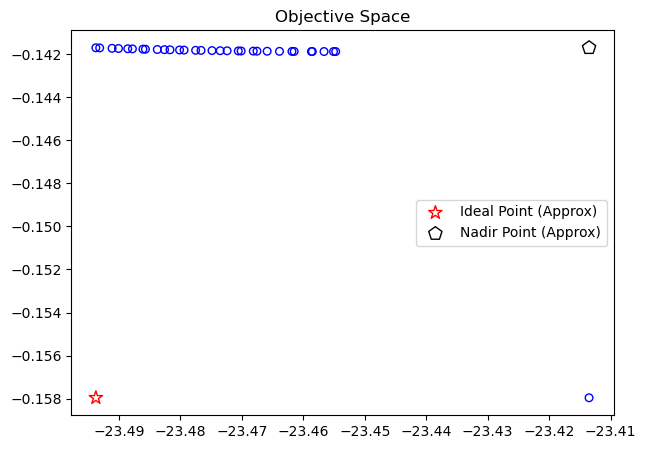

In [22]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()